# 1. Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [227]:
import os
import shutil
import numpy as np
import pandas as pd
import pickle
import cv2 as cv
import matplotlib.pyplot as plt
import praw
import requests
import json
import csv
import time
import datetime
from tqdm import tqdm
import json

# 2. Data Acquisation

#### List of Properties of a submission(post is often reffered as submission), I am manually eliminating few of them, bacuase flair of the submission is least (or not) dependent on them ie: Flair is rarely dependent on author name, or subreddit etc

##### Submission Properties: dict_keys(['all_awardings', 'allow_live_comments', 'author', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_text', 'author_flair_type', 'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post', 'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video', 'link_flair_background_color', 'link_flair_css_class', 'link_flair_richtext', 'link_flair_template_id', 'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls', 'removed_by_category', 'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler', 'steward_reports', 'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers', 'subreddit_type', 'thumbnail', 'title', 'total_awards_received', 'url', 'whitelist_status', 'wls'])


##### Reference: 
- https://praw.readthedocs.io/en/latest/index.html
- https://github.com/pushshift/apia

##### creating a reddit app instance to collect post data from r/india submreddit

In [3]:
reddit = praw.Reddit(client_id='pw8WCM92ySUjsQ', client_secret='y0MJFMWBtHXMLW2-3B2upsU2jYQ', user_agent='reddit-scrap', username='macabdul9', password='Sudo$0#1')

#### We can get the submission either by id or url


In [4]:
subm = reddit.submission(id="fxqifi")

In [5]:
subm.num_comments

127

##### Turn Around Time(TAT) for getting all comments of a post is way higher using praw with submission_id than pushshift.io api comment search below code snippets illustrate the same

In [ ]:
# start_time = time.time()
# comment_ids = []
# count = 0
# for comment in subm.comments.list():
#     comment_ids.append(comment.id)
#     print(comment.body)
#     count+=1
# print("--- %s seconds ---" % (time.time() - start_time))
# print(count)

In [ ]:
# start_time = time.time()
# comments = getPushshiftSubData(','.join(comment_ids))
# count = 0
# for comment in comments:
#     print(comment['body'])
#     count +=1
# print("--- %s seconds ---" % (time.time() - start_time))
# print(count)

##### This function will receive url of a submission, num_commnents as arg and it will return the top 10 comment and mean comment score(upvote - downvote)

In [ ]:
def get_comments(url, num_comments):
    # call api using api wrapper
    subm = reddit.submission(url=url)
    comments_body = []
    sum_score = 0
    count = 0
    if num_comments > 0:
        for i, comment in enumerate(subm.comments.list()):

            # There may be some comments which has no body
            try : 
                comments_body.append(comment.body)
            except:
                comments_body.append('')

            # There exist some comments which has not given a score
            try:
                sum_score += comment.score
            except:
                sum_score += 0            
            count += 1
            # We only need 10 comments
            if (i+1)%10==0:
                break
    try:
        mean = sum_score/count
    except:
        mean = 0.0

    return " ".join(comments_body), mean

##### Function to call and retrive the data using pushshift api


In [ ]:
def getPushshiftSubData(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=2000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

##### Properties to extract 
- A custom property is a property derived from properties or can't be extracted using pushshift submission search endpoint

In [12]:
features = [
    'allow_live_comments', 'author', 'author_premium', 'can_mod_post', 'contest_mode', 'created_utc',
    'full_link', 'id', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_self', 'is_video',
    'link_flair_text', 'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts', 'over_18',
    'parent_whitelist_status', 'permalink', 'pinned', 'score', 'selftext', 'send_replies', 'spoiler',
    'stickied', 'title', 'total_awards_received', 'url'
]
custom_features = [
    'comments', 'mean_comment_score'
]

##### Function to extract the data 

In [ ]:
def collectSubData(subm):
    # extracting all information about a submission
    feature_values = [subm.get(key) for key in features]    
    comments, mean_comment_score = get_comments(subm.get('full_link'), subm.get('num_comments')) 
    feature_values.append(comments)
    feature_values.append(mean_comment_score)
    subStats[subm.get('id')] = feature_values

##### Query Parameters and Store Variables

In [ ]:
#Subreddit to query
sub='india'

#before and after dates
after = "1559347200"  # Sat, 01 Jun 2019 00:00:00 
before = "1561939199" # Sun, 30 Jun 2019 23:59:59  
query = "" # title should have either null string more 
subCount = 0
subStats = {}

##### Extracting the data from certain time period

In [262]:
data = getPushshiftSubData(query, after, before, sub)# Will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    # print(len(data))
    if subCount % 1000 == 0:
        print(f'{subCount} submission collected')
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    data = getPushshiftSubData(query, after, before, sub)

print(len(data))

##### Write the json object into a pickle and/or store all the data into csv a file

In [ ]:
with open("Submissions-June-2019.pkl", "wb") as f:
    pickle.dump(subStats, f)

In [ ]:
df = pd.DataFrame(data=list(subStats.values()), columns = features + custom_features, index=None)

In [ ]:
df.to_csv("Submissions-June-2019.csv", index=False)

#### Notes
- To extract the large (or sufficient) amount of data above code [2. Data Acquisation] was executed in multiple python environments to decrease the amount of time taken to gather the data ie: To collect the submission of a month 2. [2. Data Acquisation] code was executed in seperate environment.
- On the other hand multiple reddit api instances (one api app instance for each running environment) also help to reduce the time to make API request faster(multiple running threads makes the request from same instance subtantially increases the waiting time)
- All submissions fromm Jan 1, 2019 to April 10, 2019 were collected for this task and stored into the csv files(pkl as well), one file for each month's data (1 file for March 1, 2020 to April 10, 2020)
- A reliable internet connection is required for uninterrupted exectution


# 3. Exploratory Data Analysis

In [3]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
import calendar
import missingno as msno
import seaborn as sns

In [4]:
# import plotly.io as pio
# pio.renderers.default = "jupyterlab"

In [5]:
plotly.offline.init_notebook_mode(connected=True)

##### Read the csv files calendar combine them into single dataframe(or file), files names are pretty much self explanatory

In [7]:
df_1 = pd.read_csv("../Data/Submissions-Jan-2019.csv")
df_2 = pd.read_csv("../Data/Submissions-Feb-2019.csv")
df_3 = pd.read_csv("../Data/Submissions-March-2019.csv")
df_4 = pd.read_csv("../Data/Submissions-April-2019.csv")
df_5 = pd.read_csv("../Data/Submissions-May-2019.csv")
df_6 = pd.read_csv("../Data/Submissions-June-2019.csv")
df_7 = pd.read_csv("../Data/Submissions-July-2019.csv")
df_8 = pd.read_csv("../Data/Submissions-Aug-2019.csv")
df_9 = pd.read_csv("../Data/Submissions-Sep-2019.csv")
df_10 = pd.read_csv("../Data/Submissions-Oct-2019.csv")
df_11 = pd.read_csv("../Data/Submissions-Nov-2019.csv")
df_12 = pd.read_csv("../Data/Submissions-Dec-2019.csv")
df_13 = pd.read_csv("../Data/Submissions-Jan-2020.csv")
df_14 = pd.read_csv("../Data/Submissions-Feb-2020.csv")
df_15 = pd.read_csv("../Data/SubmissionS-March-2020.csv")

In [8]:
# List of dataframes
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12, df_13, df_14, df_15]

In [9]:
len(dfs)

15

##### Function to iterate over month

In [10]:
def month_year_iter( start_month, start_year, end_month, end_year):
    ym_start= 12*start_year + start_month - 1
    ym_end= 12*end_year + end_month - 1
    for i, ym in enumerate(range(ym_start, ym_end)):
        y, m = divmod( ym, 12)
        yield y, m+1, dfs[i]

##### Monthly submissions

In [12]:
monthly_submissions = {}
for year, month, df in month_year_iter(1, 2019, 4, 2020):
    monthly_submissions[str(calendar.month_name[month])+" "+str(year)] = df.shape[0]


##### We might need monthly submission into our web app visualization so lets dump the dict into json file


In [228]:
with open("monthly_submission.json", 'w') as fp:
    json.dump(monthly_submissions, fp)

In [13]:
# get the months and submissions 
months = list(monthly_submissions.keys())
submissions = list(monthly_submissions.values())

##### Monthly submissions plot 

In [239]:
from change_bar_width import change_width

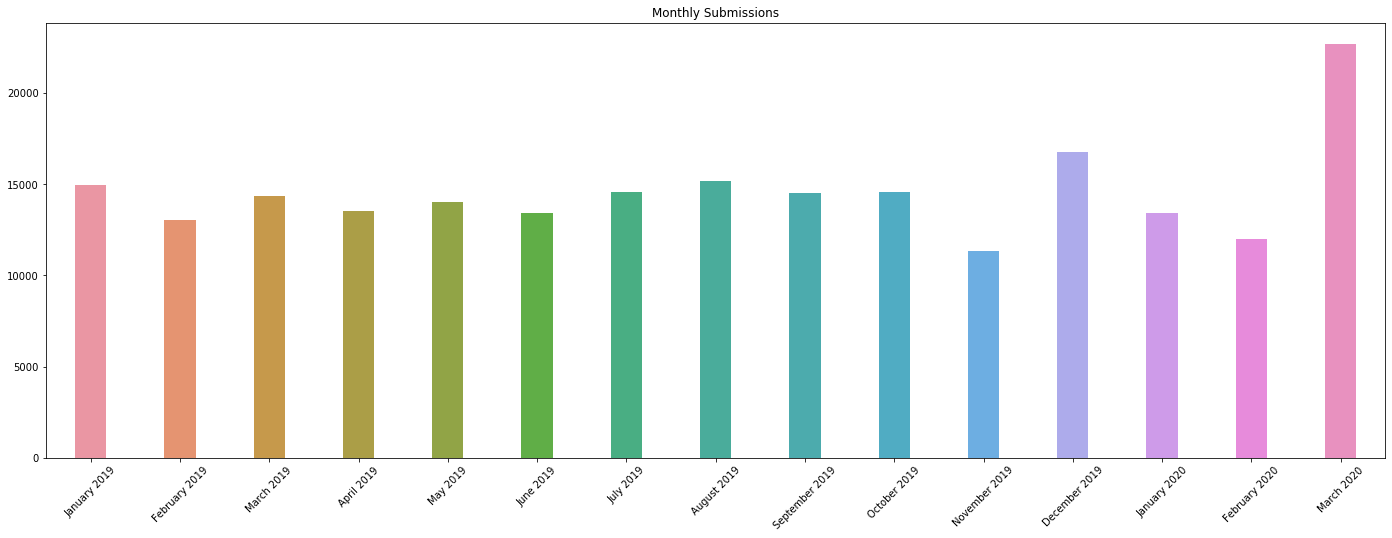

In [280]:
# monthly submissions
change_width
# plt.figure(figsize=(24, 8))
fig, ax = plt.subplots(figsize=(24, 8))
ax.set_xticklabels(months, rotation=45)
sns.barplot(months, submissions, ax=ax)
change_width(ax, .35)
plt.title("Monthly Submissions")
plt.show();

##### Nothing much ! I thought due to Covid19 outbreak we can see a spike in monthly submissions

In [264]:
# Concatenate all the Dataframes
df = pd.concat(dfs)

##### Write the combined data into csv files(We might need it later) this is one time executable script hence lets commenting it after executing

In [40]:
# df.to_csv("Submissions-Jan-2019-to-March-2020.csv", index=False)

In [25]:
# Combined datafram info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218370 entries, 0 to 22709
Data columns (total 33 columns):
allow_live_comments        134036 non-null object
author                     218370 non-null object
author_premium             63303 non-null object
can_mod_post               218370 non-null bool
contest_mode               218370 non-null bool
created_utc                218370 non-null int64
full_link                  218370 non-null object
id                         218370 non-null object
is_crosspostable           218370 non-null bool
is_meta                    218370 non-null bool
is_original_content        218370 non-null bool
is_self                    218370 non-null bool
is_video                   218370 non-null bool
link_flair_text            117692 non-null object
locked                     218370 non-null bool
media_only                 218370 non-null bool
no_follow                  218370 non-null bool
num_comments               218370 non-null int64
num_crosspost

#### It looks like plently of properties have null values lets visualise the above info into graphs
#### 1. Missing Data Plot

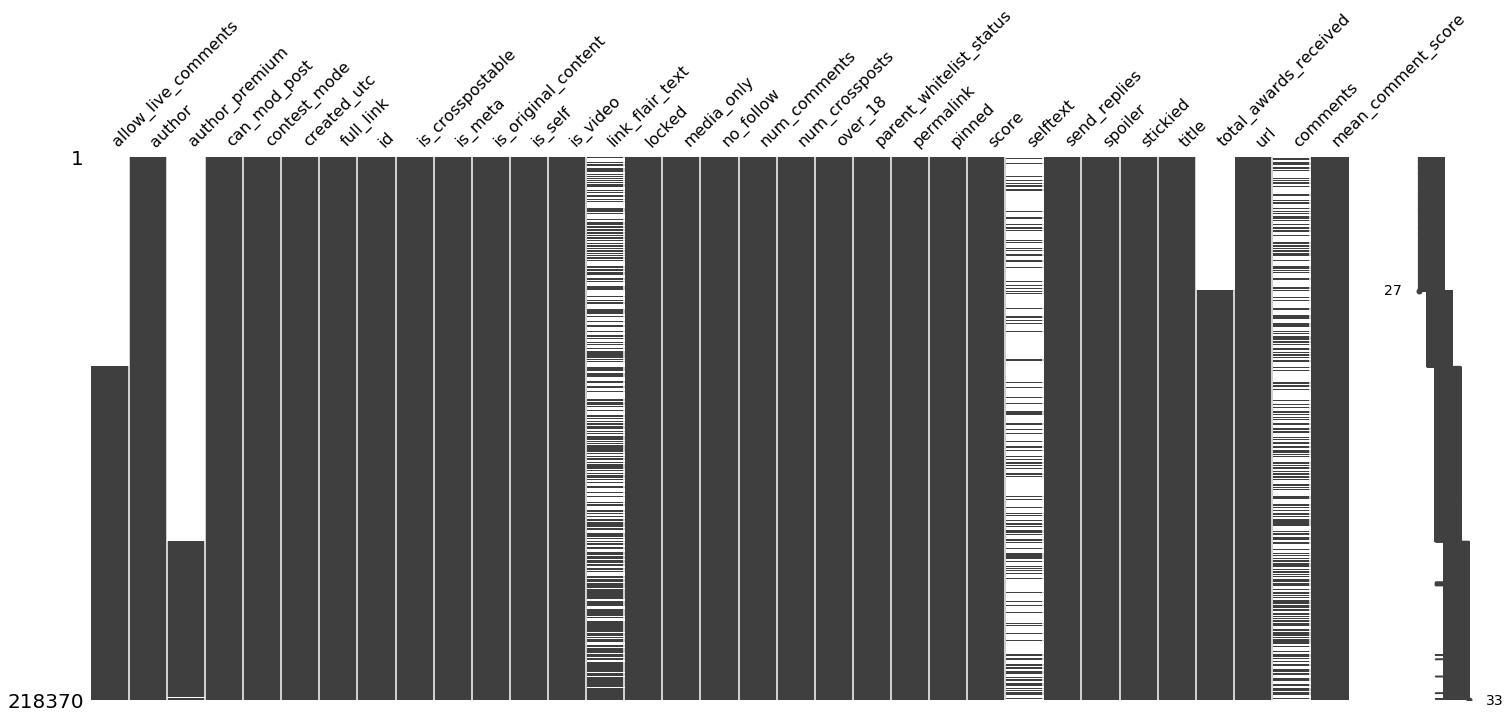

In [133]:
# plt.title("Missing Values Matrixplot")
msno.matrix(df)
plt.show()

##### Note:
- link_flair_text = flair (target variable)
- self_text = submission(post) body

##### Total Entries = 218370
##### In the missing plot we can see that there are many missing dependent and independent variables
##### Such as allo_live_comments author_premium, link_flair_text, self_text, total_awards_received, comments
##### There are lots of submissions whose target variable(flair) is missing either we have to drop those entries or we need to immpute them,  we will catch them later.

##### Bar plot of missing values | exactly how many values are missinng in each coloumn


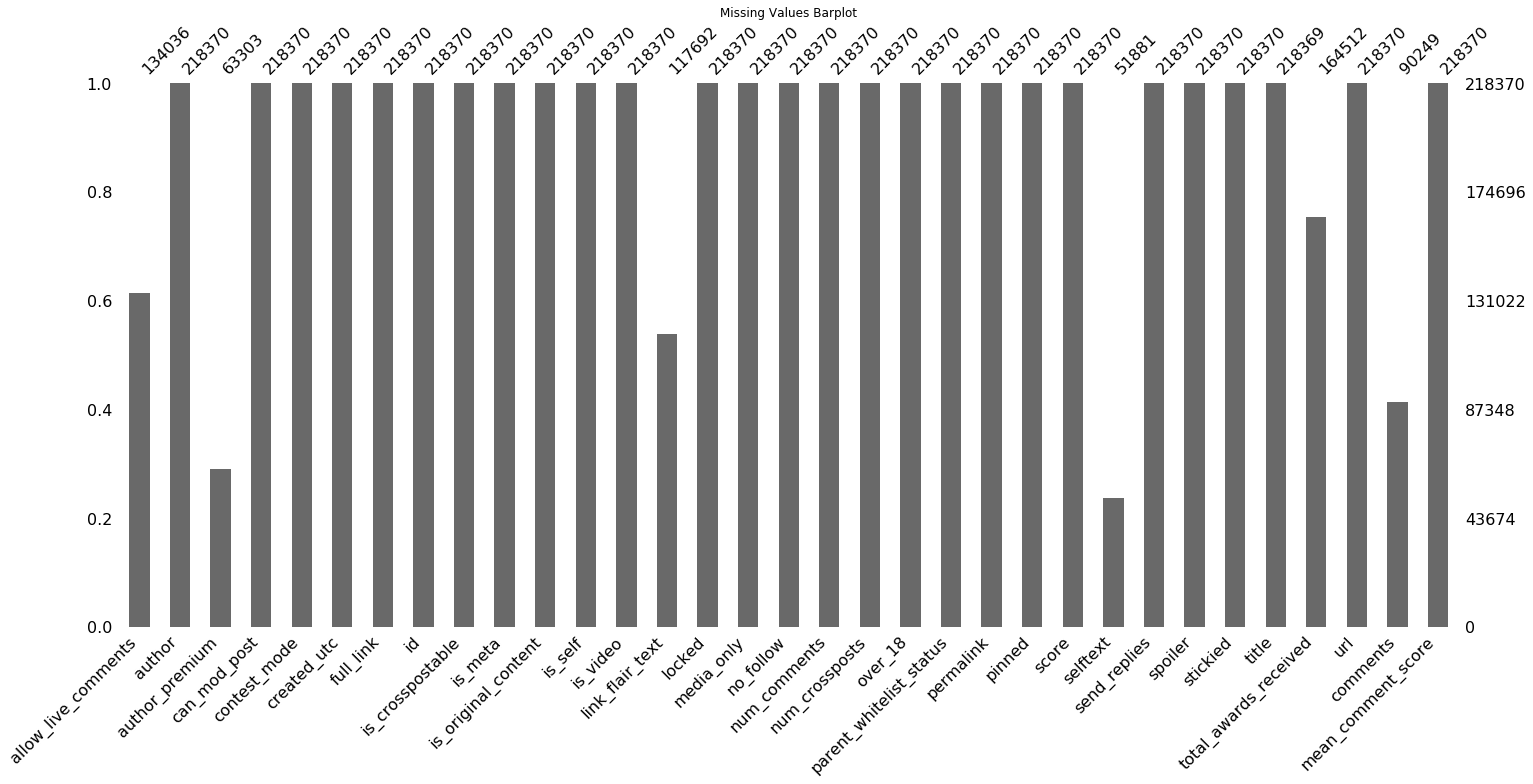

In [47]:
plt.title("Missing Values Barplot")
msno.bar(df); # This graph is a visual interpretation of df.info()
plt.show()

#### *Inference* : link_flair_text (flair) is dependent variable(target variable) and ~50% of submissions have no flair hence either I need to drop them or impute them 

In [204]:
# Get the list of flairs and corresponding frequency 
flairs_df = df.link_flair_text
flairs_df = flairs_df.fillna("Miscellaneous")
flairs, freq = np.unique(flairs_df.values, return_counts=True)

In [205]:
flairs_freq = dict(zip(flairs, freq))

In [206]:
print(flairs_freq)

{'AMA': 5, 'AMA Announcement': 2, 'All CAPS.': 752, 'Announcement': 2, 'AskIndia': 18343, 'Aug 2019 - Politics': 1, 'Business/Finance': 7277, 'CAA-NRC': 1024, 'CAA-NRC-NPR': 76, 'Casual AMA': 1, 'Coronavirus': 6757, 'Dead Link': 1, 'Demonetization': 780, 'Food': 1511, 'Foodpolitics': 1, 'Low Quality/Non OC Meme': 20, 'Low-effort self-post.': 541, 'Megathread': 1, 'Meta': 1, 'Meta.': 11, 'Meta. | Custom (Informed OP) |': 1, 'Miscellaneous': 100678, 'Non-Political': 27806, 'Not Appropriate Subreddit': 4, 'Not in English.': 657, 'PARTAYYY AGAIN :D': 1, 'Personal/Unverified Twitter.': 5, 'Photography': 3406, 'Policy/Economy': 4875, 'Politics': 32229, 'Post link Directly': 4, 'Scheduled': 693, 'Science &amp; Technology': 7, 'Science/Technology': 5346, 'Shitpost': 9, 'Sports': 1992, 'Unverified': 4, 'Verified': 1, '[R]eddiquette': 3335, '| Custom (Informed OP) |': 4, '| Image Rule Violation |': 8, '| Low-effort Self Post |': 25, '| Low-effort Self Post | Post link Directly': 1, '| Low-effort

In [207]:
len(flairs_freq)

64

##### Reddit submissions are real time data and we can see that it is highly imbalanced and imputation of target variable will lead to more data imablance and imputing dependent variable is considered as bad practice,  hence droping them is only good option for now

In [209]:
df_no_missing_flairs = df.dropna(subset=['link_flair_text'])
print(f"Dropped {flairs_freq.get('Miscellaneous')} entries ")
# delete it from flair dictionary as well
del flairs_freq['Miscellaneous']

Dropped 100678 entries 


#### Downsampling the dataset based on total submission in a flair to reduce the data imbalance. There are many redundant flairs and semantically vague flairs which should be removed. I will remove those instances which have not a threshold number of samples. Morever there are some flairs which have no meaning like "Not in English", "ALL CAPS", "Scheduled" to remove such instances we have to choose right threshold value or we may require to remove them manually

In [210]:
thresh = 760 # If a falir has less thresh samples I will remove it.
flairs_freq_downsampled = dict((key, value) for key, value in flairs_freq.items() if value > thresh )

In [265]:
# print how many valid flairs and total number of submission satisfying the criteria
print(f'total valid flairs :{len(flairs_freq_downsampled.keys())} \n total samples = {sum(flairs_freq_downsampled.values())}')
flairs_freq_downsampled

total valid flairs :13 
 total samples = 114681


{'AskIndia': 18343,
 'Business/Finance': 7277,
 'CAA-NRC': 1024,
 'Coronavirus': 6757,
 'Demonetization': 780,
 'Food': 1511,
 'Non-Political': 27806,
 'Photography': 3406,
 'Policy/Economy': 4875,
 'Politics': 32229,
 'Science/Technology': 5346,
 'Sports': 1992,
 '[R]eddiquette': 3335}

In [212]:
# drop the index
df_no_missing_flairs.reset_index(drop=True, inplace=True)

In [213]:
df_no_missing_flairs.shape

(117692, 33)

In [246]:
# get the index of all submissions to remove
index = []
for row in tqdm(range(df_no_missing_flairs.shape[0])):
    if df_no_missing_flairs.link_flair_text.values[row] not in list(flairs_freq_downsampled.keys()):
        index.append(row)

In [296]:
# drop them by indices
new_df = df_no_missing_flairs.drop(index)

In [273]:
# get the new flairs and  corresponding frequencies 
new_flairs, new_freq = np.unique(new_df.link_flair_text, return_counts=True)
new_flairs_freq = dict(zip(new_flairs, [int(each) for each in new_freq]))

In [274]:
new_flairs_freq

{'AskIndia': 18343,
 'Business/Finance': 7277,
 'CAA-NRC': 1024,
 'Coronavirus': 6757,
 'Demonetization': 780,
 'Food': 1511,
 'Non-Political': 27806,
 'Photography': 3406,
 'Policy/Economy': 4875,
 'Politics': 32229,
 'Science/Technology': 5346,
 'Sports': 1992,
 '[R]eddiquette': 3335}

##### Write the dictionary into json file we might need it in web app data visualization


In [275]:
with open("flairs_freq.json", 'w') as fp:
    json.dump(new_flairs_freq, fp)

##### % of Submissions in each flairs

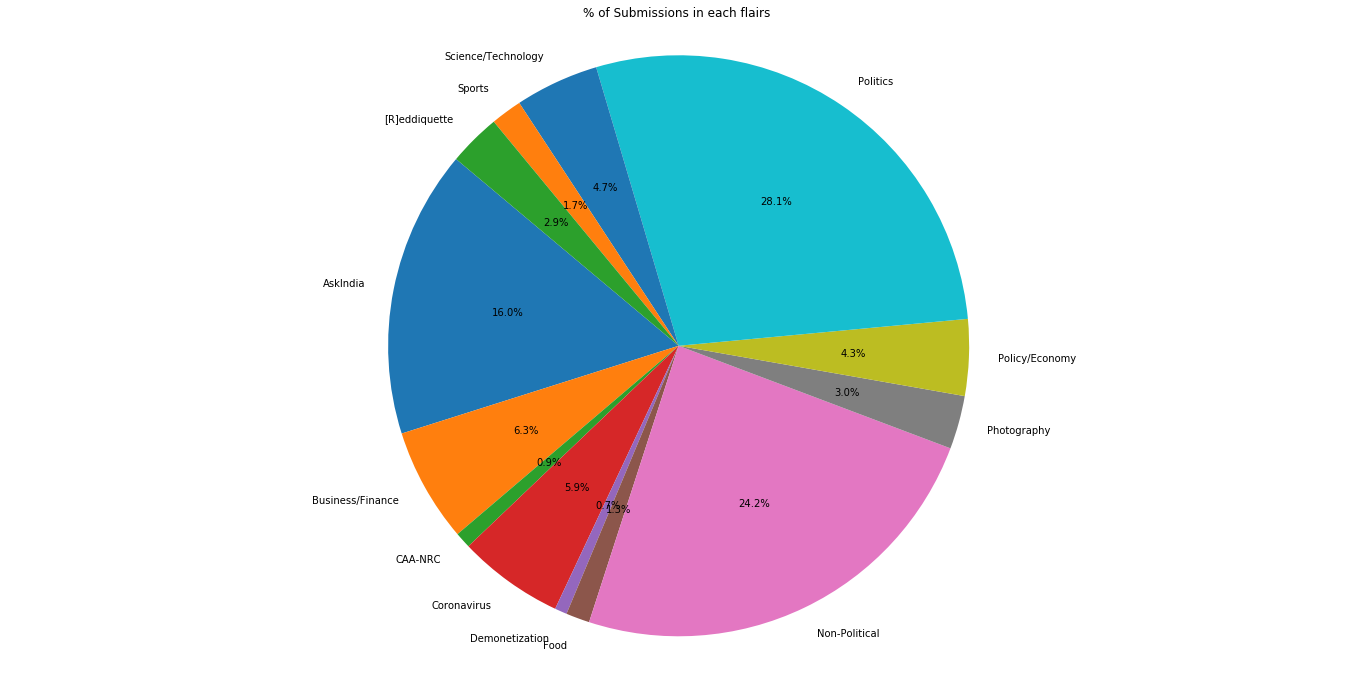

In [261]:
plt.figure(figsize=(24, 12))
plt.pie(new_freq, labels=new_flairs, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title("% of Submissions in each flairs")
plt.show()

##### selftext(body), title, and comments textual data we are going to proceed further to build text classifiers, following will be new cols in dataframe
- title + body
- title + body + comments 
##### We can impute the selftext and comments with empty string


In [297]:
new_df.selftext = new_df.selftext.fillna("")
new_df.comments = new_df.comments.fillna("")

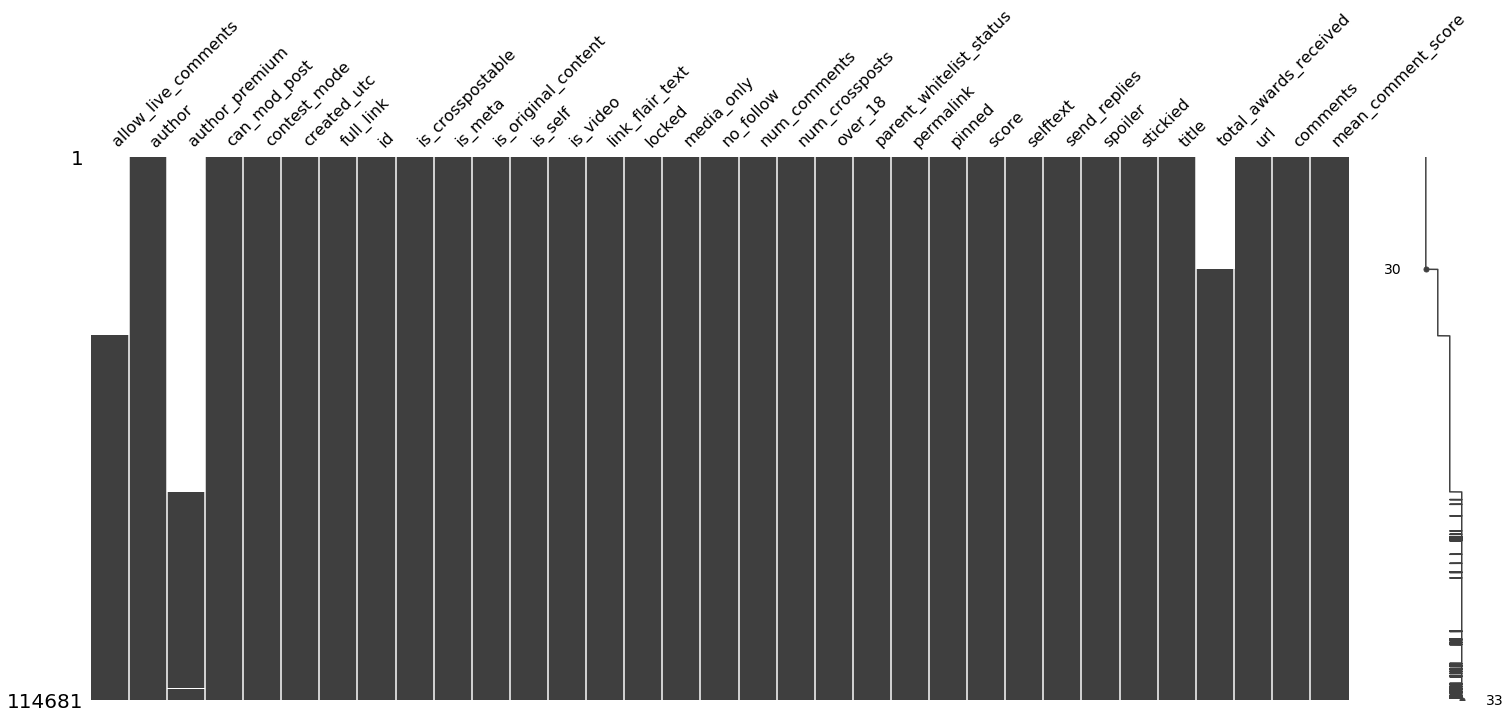

In [298]:
# Lets plot the missing matrix again
msno.matrix(new_df);

##### now we can see that we don't have any missing values in selftext and comments its time to combine them to and create new cols 

In [302]:
# concatenate the cols
df_archive = new_df

In [303]:
new_df["title_selftext"] = new_df.title + " " + new_df.selftext
new_df['title_selftext_comments'] = new_df.title + " " + new_df.selftext + " " + new_df.comments

In [305]:
# new_df.head(2)

### World Coulds of each flair

In [359]:
from wordcloud import WordCloud, STOPWORDS

In [315]:
new_df.link_flair_text.value_counts()

Politics              32229
Non-Political         27806
AskIndia              18343
Business/Finance       7277
Coronavirus            6757
Science/Technology     5346
Policy/Economy         4875
Photography            3406
[R]eddiquette          3335
Sports                 1992
Food                   1511
CAA-NRC                1024
Demonetization          780
Name: link_flair_text, dtype: int64

In [321]:
# Pandas Series for each flair
flairs = new_flairs_freq.keys()
flairs_series = []
for flair in flairs:
    flairs_series.append(new_df[new_df.link_flair_text==flair].title_selftext_comments)

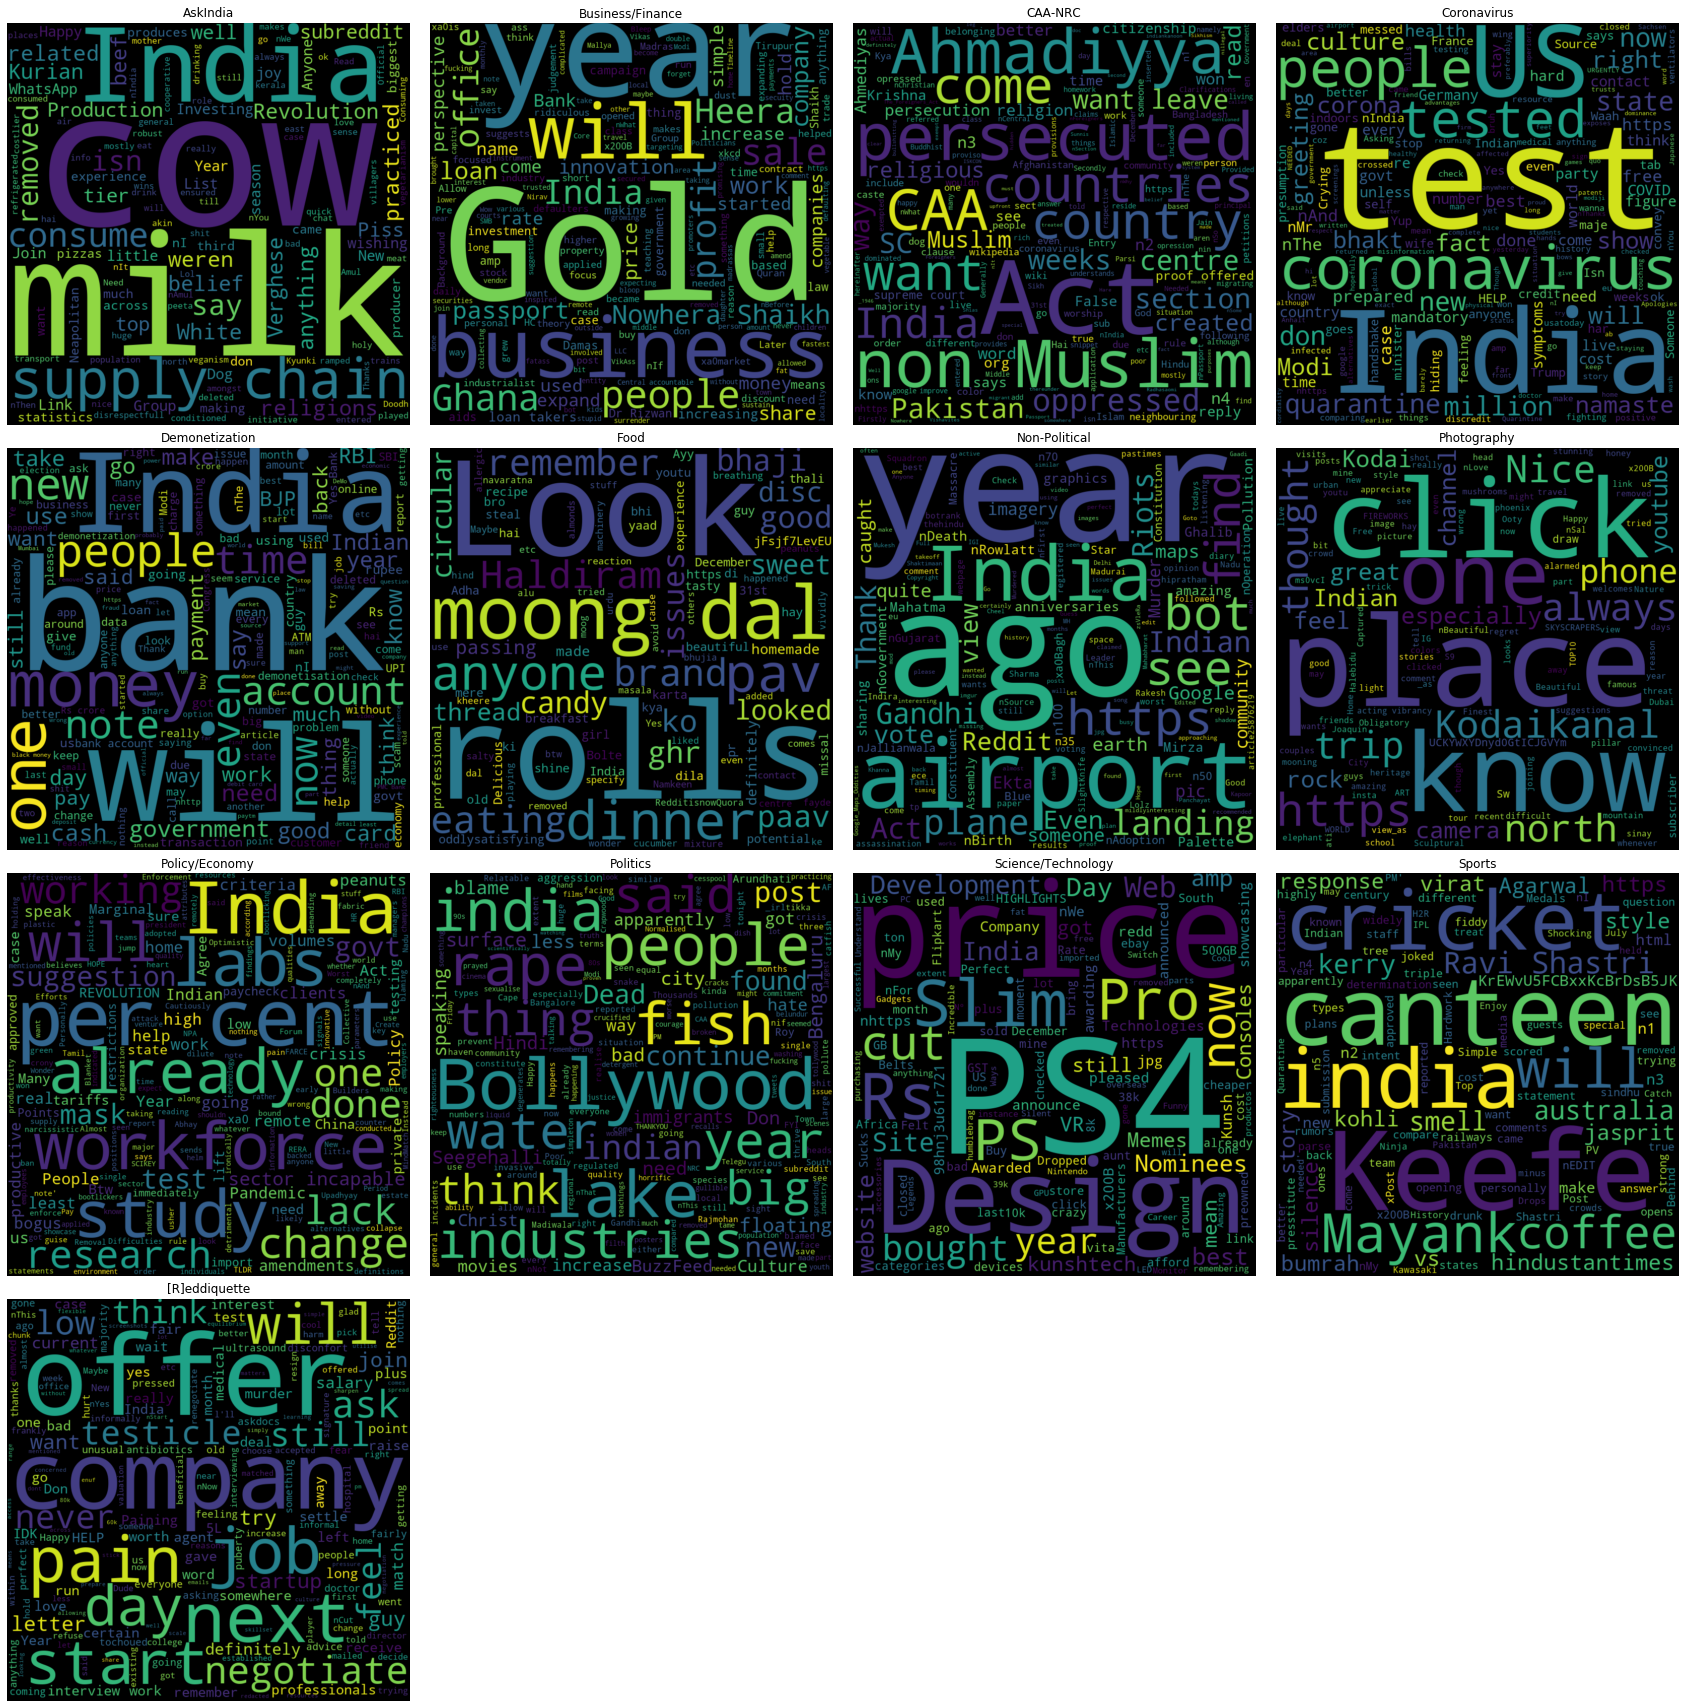

In [363]:
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 4
for i, pds in zip(range(1, columns*rows +1), flairs_series):
    text = pds.values
    wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
    fig.add_subplot(rows, columns, i)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(list(flairs)[i-1])
    plt.tight_layout(pad=1)
    plt.axis('off')
plt.show()